### Support Vector Machines

• Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.

• In this section, we will develop the intuition behind support vector machines and their use in classification problems.

• We begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as states

# Use seaborn plotting defaults
import seaborn as sns; sns.set()

### Motivating Support Vector Machines

• As part of our disussion of Bayesian classification (see In Depth: Naive Bayes Classification), we learned a simple model describing the distribution of each underlying class, and used these generative models to probabilistically determine labels for new points.

• That was an example of generative classification; here we will consider instead discriminative classification: rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

• As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated:

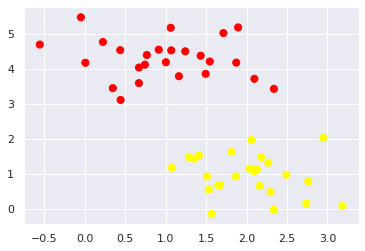

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

• A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.

• For two dimensional data like that shown here, this is a task we could do by hand.

• But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

• We can draw them as follows:

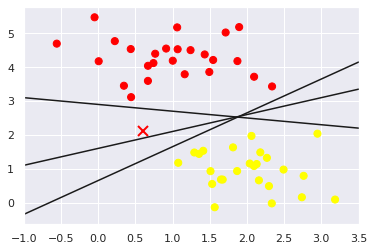

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color = 'red', markeredgewidth = 2, markersize = 10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

• These are three very different separators which, nevertheless, perfectly discriminate between these samples.

• Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!

• Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

### Support Vector Machines: Maximizing the Margin

• Support vector machines offer one way to improve on this.

• The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point.

• Here is an example of how this might look:

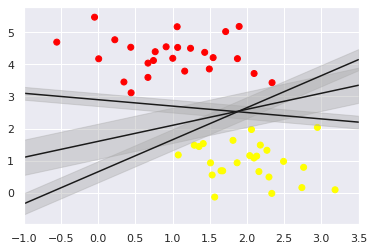

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor = 'none',
                    color = '#AAAAAA', alpha = 0.4)
plt.xlim(-1, 3.5);

• In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.

• Support vector machines are an example of such a maximum margin estimator.

### Fitting a support vector machine

• Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.

• For the time being, we will use a linear kernel and set the C parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [5]:
from sklearn.svm import SVC
model = SVC(kernel = 'linear', C = 1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

• To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [6]:
def plot_scv_decision_function(model, ax = None, plot_support = True):
    """Plot the decision function for 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # Plot decision boundary & margins
    ax.contour(X, Y, P, colors = 'k',
              levels = [-1, 0, 1], alpha = 0.5)
    
    # Plot support vector
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                  model.support_vectors_[:, 1],
                  s=300, linewidth = 1, facecolor = 'none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

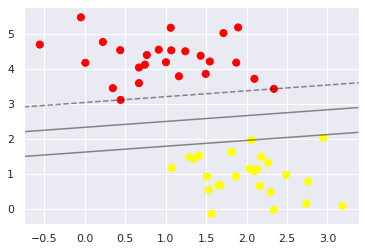

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap = 'autumn')
plot_scv_decision_function(model);

• This is the dividing line that maximizes the margin between the two sets of points.

• Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure.

• These points are the pivotal elements of this fit, and are known as the support vectors, and give the algorithm its name.

• In Scikit-Learn, the identity of these points are stored in the support_vectors_ attribute of the classifier:

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

• A key to this classifier's success is that for the fit, only the position of the support vectors matter;

• Any points further from the margin which are on the correct side do not modify the fit! Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

• We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

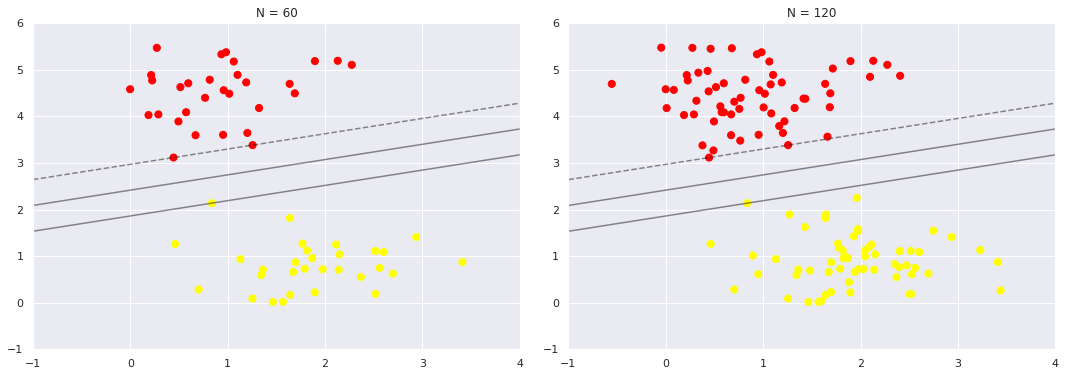

In [11]:
def plot_svm(N = 10, ax = None):
    X, y = make_blobs(n_samples=200, centers=2,
                     random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap = 'autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_scv_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize = (16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

• In the left panel, we see the model and the support vectors for 60 training points.

• In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.

• This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

• If you are running this notebook live, you can use IPython's interactive widgets to view this feature of the SVM model interactively:

In [15]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 50, 100, 150, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 50, 100, 150, 200), value=10), Output()), _dom_cl…

### Beyond linear boundaries: Kernel SVM

• Where SVM becomes extremely powerful is when it is combined with kernels.

• We have seen a version of kernels before, in the basis function regressions of In Depth: Linear Regression.

• There we projected our data into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

• In SVM models, we can use a version of the same idea. To motivate the need for kernels, let's look at some data that is not linearly separable:

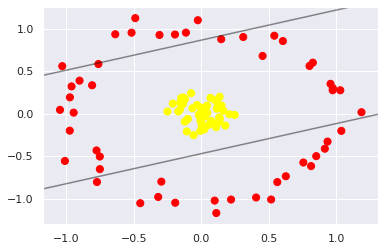

In [25]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=0.1, noise=0.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
#plt.plot(figsize = (50, 10))
plot_scv_decision_function(clf, plot_support=False)

• It is clear that no linear discrimination will ever be able to separate this data.

• But we can draw a lesson from the basis function regressions in In Depth: Linear Regression, and think about how we might project the data into a higher dimension such that a linear separator would be sufficient.

• For example, one simple projection we could use would be to compute a radial basis function centered on the middle clump:

In [26]:
r = np.exp(-(X ** 2).sum(1))

• We can visualize this extra data dimension using a three-dimensional plot—if you are running this notebook live, you will be able to use the sliders to rotate the plot:

In [29]:
from mpl_toolkits import mplot3d

def plot3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot3D, elev=[-180, -90, 0, 90, 180], azip=[-180, 180],
        X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-180, -90, 0, 90, 180), value=-180), IntSlider(val…

• We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, r=0.7.

• Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.

• In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

• One strategy to this end is to compute a basis function centered at every point in the dataset, and let the SVM algorithm sift through the results.

• This type of basis function transformation is known as a kernel transformation, as it is based on a similarity relationship (or kernel) between each pair of points.

• A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.

• However, because of a neat little procedure known as the kernel trick, a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection! This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

• In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the kernel model hyperparameter:

In [31]:
clf = SVC(kernel='rbf', C=1E6, gamma='scale')
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

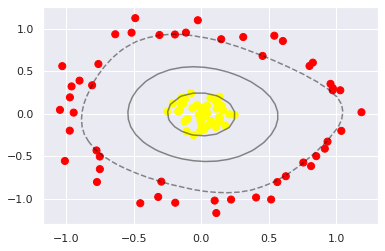

In [35]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_scv_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
           s=300, lw=1, facecolors='none');

• Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.

• This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.